In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [3]:
n_rounds = 1
data = pd.read_csv('../data/countTable.0.CTCF_r3.tsv.gz', sep='\t', header=None)
data.columns = ['seq'] + [i for i in range(n_rounds+1)]
# data = data.sample(n=10000)
# data.index = range(len(data))
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [10]:
print(len(dataset))

120096


In [95]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=2).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.PoissonLoss()

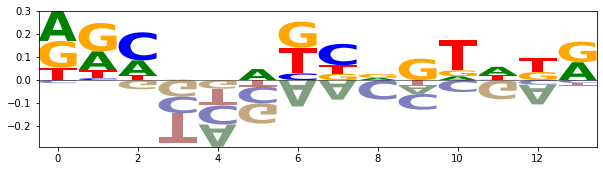

In [96]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [97]:
print(model.log_eta.weight)

Parameter containing:
tensor([[-0.3078],
        [-2.1487]], requires_grad=True)


In [98]:
print(model.log_activity.weight)

Parameter containing:
tensor([[-0.6726, -0.1618],
        [ 0.3633, -0.4340],
        [ 1.6171,  0.2777]], requires_grad=True)


In [69]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 0.0274,  0.0936, -0.1227,  0.0586, -0.0324,  0.0250, -0.0428,
            -0.1059, -0.0542, -0.0705,  0.1246, -0.0104,  0.0855, -0.0366],
           [-0.0654, -0.0933,  0.1254, -0.0061,  0.0947,  0.0085, -0.0170,
            -0.0738, -0.0257,  0.1174,  0.1291,  0.0786, -0.0771, -0.0002],
           [ 0.1313, -0.1225, -0.0545,  0.1308,  0.1110, -0.1039,  0.0978,
            -0.1161, -0.0972, -0.0167, -0.1003,  0.0840,  0.1068, -0.0132],
           [-0.0525,  0.1062,  0.0753, -0.0339,  0.0794, -0.0959, -0.0743,
             0.0016,  0.0062,  0.0201, -0.0404, -0.0984, -0.0198, -0.0109]]]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.6863, -0.9701],
         [ 0.1088,  0.1013]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0844],
         [-0.1980]], requires_grad=True)]

In [99]:
l2 += mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, log_each=1)

Epoch:  1, Loss: 0.880
Epoch:  2, Loss: 0.850
Epoch:  3, Loss: 0.849
Epoch:  4, Loss: 0.849
Epoch:  5, Loss: 0.849
Epoch:  6, Loss: 0.849
Epoch:  7, Loss: 0.849
Epoch:  8, Loss: 0.849
Epoch:  9, Loss: 0.848
Epoch: 10, Loss: 0.848


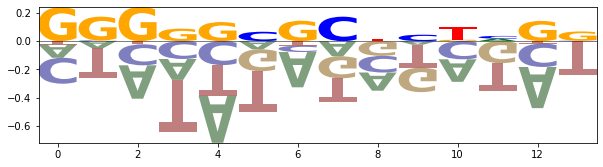

In [100]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

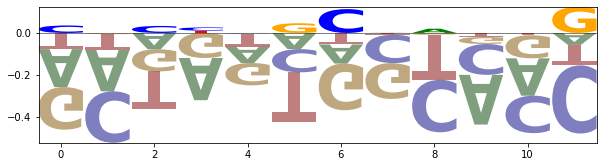

In [101]:
weights = model.conv_mono[2].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

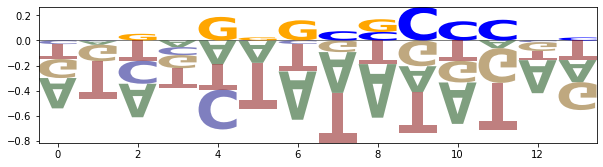

In [82]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

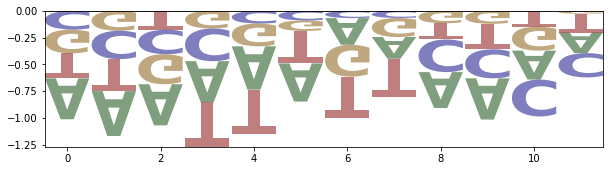

In [83]:
weights = model.conv_mono[2].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [84]:
print(model.log_eta.weight)

Parameter containing:
tensor([[ 0.2947],
        [-0.2382]], requires_grad=True)


In [85]:
print(model.log_activity.weight)

Parameter containing:
tensor([[-4.9551e-07, -2.1618e-01],
        [ 3.6056e-07, -1.0918e+00],
        [-2.0377e-07,  1.2980e+00]], requires_grad=True)


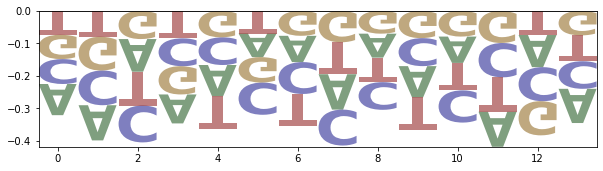

In [42]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [63]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())

In [64]:
all_outputs

[array([0.49903935, 0.5009606 ], dtype=float32),
 array([0.49979138, 0.5002087 ], dtype=float32),
 array([0.49843752, 0.50156254], dtype=float32),
 array([0.50156015, 0.49843988], dtype=float32),
 array([0.5006052 , 0.49939477], dtype=float32),
 array([0.4982915, 0.5017085], dtype=float32),
 array([0.50184476, 0.49815524], dtype=float32),
 array([0.4996872, 0.5003128], dtype=float32),
 array([0.49957907, 0.5004209 ], dtype=float32),
 array([0.4999181 , 0.50008196], dtype=float32),
 array([0.50064397, 0.49935612], dtype=float32),
 array([0.498691, 0.501309], dtype=float32),
 array([0.49938223, 0.50061774], dtype=float32),
 array([0.49759766, 0.50240237], dtype=float32),
 array([0.5010245 , 0.49897552], dtype=float32),
 array([0.4995465, 0.5004535], dtype=float32),
 array([0.49961993, 0.5003801 ], dtype=float32),
 array([0.49999624, 0.5000038 ], dtype=float32),
 array([0.5012103 , 0.49878967], dtype=float32),
 array([0.50254333, 0.4974566 ], dtype=float32),
 array([0.49843812, 0.5015619 

In [102]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())

In [ ]:
all_outputs